- Load necessary module

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [2]:
mat = io.loadmat('temp.mat')
model = {}
model['H'] = mat['H']
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
model['Ns'] = 1 ## need to change nb of stream in channel realization, this case 1
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 2

In [3]:
for key in model:
    print(key)

Nr
Nc
H
Nrf
Nt
Ns
Wopt
realization
Nray
Ar
Fopt
At


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

### Helper function for Cross entropy Beamforming

In [4]:
def phase_shifter(N):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**N
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i
    return np.around(ps, decimals=2)

def generate_candidat(S,model,phase_value,ps_system_proba):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    for i in range(S):
        for j in range(model['Nt']):
            for k in range(model['Nrf']):
                F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    return F_rf

def compute_Fbb(F_rf,model):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
    channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  model['H'][:,:,channel_index]@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
    return F_bb

def optimal_combiner(model, channel_index):
    """
    Compute the optimal combiner by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(model['H'][:,:,channel_index], full_matrices=True)
    V = V.conj().T
    # Fopt[:,:,reali] = V[0:Nt,0:Ns]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Wopt

def update_pmf(F_elites,phase_value,nb_elite):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    for i in range(model['Nt']):
        for j in range(model['Nrf']):
            unique, counts = np.unique(F_elites[:,i,j], return_counts=True)
            value_count = dict(zip(unique, counts))
            for k in range(nb_state):
                if phase_value[k] in value_count:   
                    proba_est = value_count[phase_value[k]]/nb_elite
                else:
                    proba_est = 0
                ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    return ps_system_proba

### Define Phase shiter

In [5]:
nb_bit = 2
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [6]:
phase_value = phase_shifter(nb_bit)
phase_value

array([ 1.+0.j,  0.+1.j, -1.+0.j, -0.-1.j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [20]:
nb_elite = 40
S = 200
channel_index = 0
Wopt = optimal_combiner(model,channel_index)
nb_iterate = 20
ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
print(ps_system_proba)
R_max = []
for i in range(nb_iterate):
    F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
    F_bb = compute_Fbb(F_rf,model)
    SNR = 10**(10/10)
    R = np.zeros((S))
    for j in range(S):
        R[j] = np.log2(np.linalg.det(np.eye(model['Ns']))+SNR/model['Ns']*np.linalg.pinv(Wopt)@model['H'][:,:,channel_index]@F_rf[j,:,:]@F_bb[j,:,:]@F_bb[j,:,:].conj().T@F_rf[j,:,:].conj().T@model['H'][:,:,channel_index].conj().T@Wopt).real
    R_sort_index = np.argsort(R)[::-1][:nb_elite]
    R_max.append(R[R_sort_index[0]])
    F_elites = F_rf[R_sort_index,:,:]
    ps_system_proba = update_pmf(F_elites,phase_value,nb_elite)


[[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]



[14.484331271178046, 14.769515924197057, 14.77480057133789, 14.598562356583448, 15.020118829507526, 15.621836540501022, 15.815984693996308, 16.21626427496758, 16.372710257778, 16.547310857034002, 16.904722699240736, 16.989758635458408, 17.14738393176303, 17.314304138449167, 17.334955225727786, 17.381769737604095, 17.51270175074149, 17.565032563124003, 17.57174428544936, 17.632544932354783]


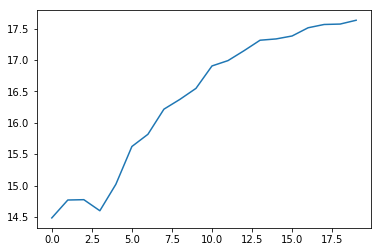

In [21]:
print(R_max)
plt.plot(R_max)

In [22]:
np.around(ps_system_proba, decimals=2)

array([[[0.03, 0.65, 0.33, 0.  ],
        [0.08, 0.24, 0.53, 0.15]],

       [[0.97, 0.03, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 1.  , 0.  ]],

       [[1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.95, 0.05]],

       [[0.06, 0.64, 0.3 , 0.  ],
        [0.97, 0.03, 0.  , 0.  ]],

       [[0.  , 0.84, 0.  , 0.16],
        [0.91, 0.08, 0.  , 0.  ]],

       [[1.  , 0.  , 0.  , 0.  ],
        [0.42, 0.  , 0.  , 0.58]],

       [[0.  , 0.27, 0.  , 0.73],
        [0.  , 0.17, 0.82, 0.  ]],

       [[0.  , 0.56, 0.44, 0.  ],
        [0.  , 1.  , 0.  , 0.  ]],

       [[0.05, 0.62, 0.33, 0.01],
        [0.52, 0.48, 0.  , 0.  ]],

       [[0.  , 0.53, 0.47, 0.  ],
        [0.  , 1.  , 0.  , 0.  ]],

       [[0.  , 0.21, 0.  , 0.79],
        [0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 1.  ],
        [0.  , 0.  , 1.  , 0.  ]],

       [[0.13, 0.65,